In [1]:
import os, sys
import torch
from sklearn import metrics
import numpy as np
import math
import itertools
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from model import RFFGP_Reg
from loss import square_loss
from train import train_model

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA:", torch.cuda.get_device_name(device))
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS (Apple Metal)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("Final device:", device)

Using CPU
Final device: cpu


In [2]:
# Training/validation data: 0 to 2π with noise
n_samples = 25_000
x_train_val = torch.linspace(0, 2 * torch.pi, n_samples).unsqueeze(1) 
y_train_val = torch.sin(x_train_val) + 0.15 * torch.randn_like(x_train_val) 

# Split training and validation
n_train = int(n_samples * 0.75)  # Using 75/25 split since we have separate test set
indices = torch.randperm(n_samples)
train_idx = indices[:n_train]
val_idx = indices[n_train:]

train_dataset = TensorDataset(x_train_val[train_idx], y_train_val[train_idx])
val_dataset = TensorDataset(x_train_val[val_idx], y_train_val[val_idx])

# Test data: extended range with no noise
n_test = 200
x_test = torch.linspace(-0.5 * torch.pi, 2.5 * torch.pi, n_test).unsqueeze(1)  # Extended range
y_test = torch.sin(x_test)  # No noise

test_dataset = TensorDataset(x_test, y_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1_000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1_000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1_000, shuffle=False)

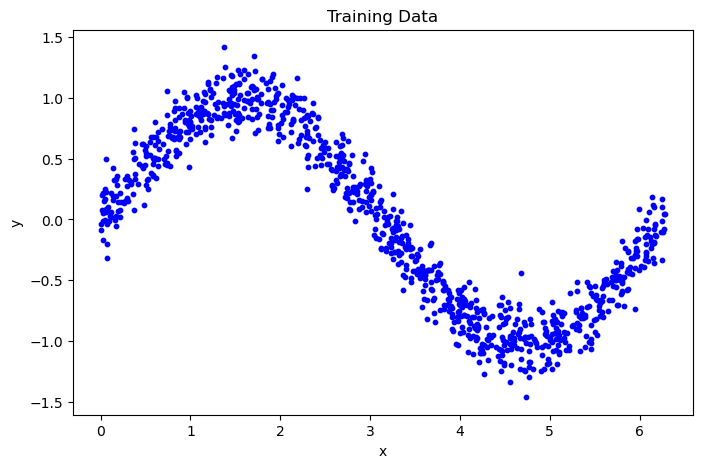

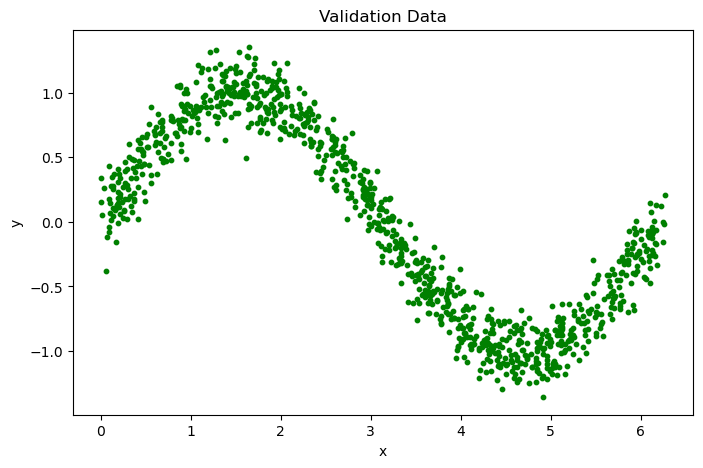

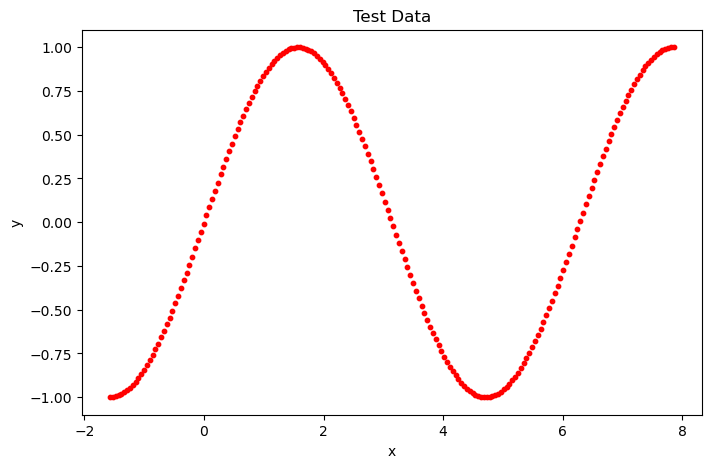

In [3]:
# --- Plotting code ---
# Helper to extract full tensors from a DataLoader
def get_full_batch(loader):
    for xb, yb in loader:
        return xb, yb

x_train, y_train = get_full_batch(train_loader)
x_val, y_val     = get_full_batch(val_loader)
x_test, y_test   = get_full_batch(test_loader)

# Plot train data
plt.figure(figsize=(8,5))
plt.scatter(x_train.numpy(), y_train.numpy(), color='blue', s=10)
plt.title("Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot validation data
plt.figure(figsize=(8,5))
plt.scatter(x_val.numpy(), y_val.numpy(), color='green', s=10)
plt.title("Validation Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot test data
plt.figure(figsize=(8,5))
plt.scatter(x_test.numpy(), y_test.numpy(), color='red', s=10)
plt.title("Test Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [4]:
%reload_ext autoreload
rank= 1000
lengthscale = 0.25
outputscale = 1.0
sngp_model = RFFGP_Reg(in_features=1,
                       out_features=1,
                       rank = rank,
                       lengthscale= lengthscale,
                       outputscale= outputscale).to(device)

print(sngp_model)

RFFGP_Reg(
  (linear): Linear(in_features=1000, out_features=1, bias=False)
)


In [5]:
trained_model, info = train_model(sngp_model, device, train_loader, val_loader, l2pen_mag=0.0,
                                  n_epochs=1_000, lr=0.005, do_early_stopping=True, 
                                  model_filename="results/models/sngp_best_model.pth")

  0%|          | 0/1001 [00:00<?, ?it/s, tr_loss=nan, tr_sqloss=nan, tr_mse=nan, va_loss=tensor(132.0744), va_sqloss=3.35e+3, va_mse=3.74, batch_done=18]

tensor([[ 1.1658e-02],
        [ 2.1680e-02],
        [-1.2072e-02],
        [ 7.4509e-03],
        [-2.4574e-02],
        [ 4.2836e-03],
        [ 1.9414e-02],
        [ 1.7113e-02],
        [ 1.3769e-02],
        [ 4.1343e-02],
        [-5.0889e-03],
        [-9.7600e-03],
        [-5.5818e-03],
        [ 1.7558e-02],
        [ 3.6816e-03],
        [-2.3553e-02],
        [-3.1182e-02],
        [ 1.7692e-02],
        [ 1.3247e-03],
        [-2.7760e-03],
        [ 1.2771e-02],
        [-2.8703e-02],
        [-1.0244e-02],
        [-6.1984e-03],
        [ 1.1324e-02],
        [ 1.7405e-02],
        [ 1.2756e-02],
        [ 1.0812e-02],
        [ 1.1304e-02],
        [ 2.2835e-02],
        [-6.8053e-03],
        [ 7.8456e-04],
        [-2.4485e-02],
        [-5.2895e-03],
        [-2.4176e-02],
        [ 4.8579e-03],
        [ 5.1376e-03],
        [ 1.7689e-02],
        [-3.5549e-03],
        [ 3.7707e-02],
        [-2.7978e-02],
        [ 1.1063e-02],
        [-5.5131e-03],
        [-1

  0%|          | 2/1001 [00:00<02:26,  6.80it/s, tr_loss=49.8, tr_sqloss=49.8, tr_mse=0.951, va_loss=tensor(5.9455), va_sqloss=137, va_mse=0.155, batch_done=19] 

tensor([[ 0.4500],
        [-0.2311],
        [-0.8566],
        [-0.7815],
        [ 0.9846],
        [-0.7271],
        [-0.2778],
        [ 0.5634],
        [-0.3788],
        [-0.1437],
        [-1.0068],
        [-0.5109],
        [-1.0097],
        [ 0.7884],
        [ 0.0973],
        [ 0.9697],
        [ 0.5056],
        [ 0.7576],
        [ 0.2415],
        [-0.9607],
        [-0.6127],
        [ 1.0008],
        [ 0.2401],
        [-0.9967],
        [-0.5336],
        [ 0.7995],
        [-0.6178],
        [-0.4790],
        [-0.6627],
        [-0.1966],
        [-1.0117],
        [-0.7488],
        [ 0.9834],
        [-1.0081],
        [ 0.9845],
        [-0.4236],
        [-0.7671],
        [ 0.6156],
        [-0.7737],
        [-0.2279],
        [ 0.6391],
        [-0.6664],
        [-1.0093],
        [-0.5501],
        [-0.8712],
        [-0.5130],
        [-0.9140],
        [ 0.4663],
        [-0.2146],
        [ 0.5803],
        [-0.4952],
        [-0.9905],
        [-0.

  0%|          | 3/1001 [00:00<02:45,  6.04it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.432, va_loss=tensor(5.9891), va_sqloss=137, va_mse=0.155, batch_done=19]

tensor([[-7.4819e-01],
        [ 1.4964e-01],
        [ 9.3564e-01],
        [ 9.8552e-01],
        [ 9.9127e-01],
        [ 1.4366e-01],
        [ 5.3256e-01],
        [-3.7308e-01],
        [-6.3738e-01],
        [-9.3695e-01],
        [-7.4554e-01],
        [ 4.8650e-01],
        [ 3.4170e-01],
        [-9.9900e-01],
        [-2.6424e-01],
        [ 9.3465e-01],
        [-9.6092e-01],
        [ 3.4095e-01],
        [ 9.1931e-01],
        [ 2.1638e-02],
        [ 2.2844e-01],
        [-4.3268e-02],
        [-1.0066e+00],
        [-7.0722e-02],
        [ 7.4056e-01],
        [ 1.0095e+00],
        [ 4.5280e-01],
        [-1.0104e+00],
        [ 1.0045e+00],
        [-9.5936e-02],
        [ 9.0463e-01],
        [-5.5942e-01],
        [ 9.9948e-01],
        [-8.9655e-01],
        [-1.0257e+00],
        [ 4.9004e-02],
        [ 9.6709e-01],
        [-8.7643e-01],
        [ 5.9269e-01],
        [ 9.4450e-01],
        [-8.6864e-01],
        [-1.7610e-01],
        [-9.5761e-01],
        [-8

  0%|          | 4/1001 [00:00<03:01,  5.50it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.432, va_loss=tensor(5.9071), va_sqloss=137, va_mse=0.155, batch_done=19]

tensor([[-0.7543],
        [ 0.1424],
        [ 0.9250],
        [ 0.9579],
        [ 0.9639],
        [ 0.1367],
        [ 0.5134],
        [-0.3771],
        [-0.6337],
        [-0.9470],
        [-0.7310],
        [ 0.4801],
        [ 0.3232],
        [-0.9915],
        [-0.2624],
        [ 0.9121],
        [-0.9523],
        [ 0.3380],
        [ 0.9068],
        [ 0.0159],
        [ 0.2172],
        [-0.0370],
        [-0.9993],
        [-0.0767],
        [ 0.7413],
        [ 0.9925],
        [ 0.4301],
        [-1.0097],
        [ 0.9795],
        [-0.1056],
        [ 0.8869],
        [-0.5667],
        [ 0.9732],
        [-0.8840],
        [-1.0208],
        [ 0.0531],
        [ 0.9584],
        [-0.8878],
        [ 0.5806],
        [ 0.9348],
        [-0.8544],
        [-0.1960],
        [-0.9489],
        [-0.8435],
        [ 0.6798],
        [ 0.8863],
        [-1.0104],
        [ 0.7946],
        [ 0.9742],
        [-0.0397],
        [ 0.5476],
        [ 0.8077],
        [-0.

  0%|          | 5/1001 [00:01<03:35,  4.62it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.432, va_loss=tensor(5.9817), va_sqloss=137, va_mse=0.155, batch_done=14]

tensor([[-8.1347e-01],
        [-1.0124e+00],
        [-3.9327e-01],
        [ 4.4215e-01],
        [ 7.4646e-01],
        [-6.9072e-01],
        [-9.2028e-02],
        [ 2.8984e-01],
        [ 3.2745e-01],
        [ 6.3158e-01],
        [ 2.5318e-01],
        [-9.1372e-01],
        [-6.0970e-01],
        [ 8.6236e-01],
        [-1.0021e+00],
        [ 1.4884e-01],
        [-3.3691e-01],
        [ 1.3810e-01],
        [-3.3926e-01],
        [-1.1748e-01],
        [-1.9994e-01],
        [-8.6577e-01],
        [-5.4246e-01],
        [-1.3252e-01],
        [-5.4846e-01],
        [ 3.2645e-01],
        [-9.4978e-01],
        [-4.4942e-01],
        [-7.2260e-01],
        [-6.0216e-01],
        [-6.4937e-01],
        [-9.5849e-01],
        [ 9.8377e-01],
        [-8.8699e-01],
        [-3.7242e-01],
        [-8.7834e-01],
        [ 7.5834e-01],
        [-3.8895e-01],
        [ 1.0021e+00],
        [-3.1876e-01],
        [ 7.6100e-01],
        [ 4.2410e-01],
        [-1.0064e+00],
        [-6

  1%|          | 6/1001 [00:01<03:27,  4.80it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.431, va_loss=tensor(5.9313), va_sqloss=137, va_mse=0.155, batch_done=19]

tensor([[ 0.4447],
        [-0.2388],
        [-0.8679],
        [-0.7829],
        [ 0.9801],
        [-0.7215],
        [-0.2856],
        [ 0.5517],
        [-0.3840],
        [-0.1341],
        [-0.9975],
        [-0.4941],
        [-0.9992],
        [ 0.7885],
        [ 0.0959],
        [ 0.9677],
        [ 0.5151],
        [ 0.7588],
        [ 0.2547],
        [-0.9658],
        [-0.6022],
        [ 0.9894],
        [ 0.2457],
        [-0.9858],
        [-0.5283],
        [ 0.7989],
        [-0.6072],
        [-0.4782],
        [-0.6522],
        [-0.2040],
        [-0.9992],
        [-0.7459],
        [ 0.9791],
        [-0.9982],
        [ 0.9691],
        [-0.4118],
        [-0.7669],
        [ 0.6076],
        [-0.7744],
        [-0.2253],
        [ 0.6468],
        [-0.6560],
        [-0.9990],
        [-0.5331],
        [-0.8833],
        [-0.4962],
        [-0.9179],
        [ 0.4591],
        [-0.2114],
        [ 0.5893],
        [-0.4790],
        [-0.9872],
        [-0.

  1%|          | 7/1001 [00:01<03:25,  4.84it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.432, va_loss=tensor(5.9293), va_sqloss=138, va_mse=0.155, batch_done=19]

tensor([[ 7.7411e-01],
        [-4.0521e-01],
        [ 7.0192e-01],
        [ 8.9900e-01],
        [ 7.8732e-01],
        [ 7.1096e-01],
        [ 8.3337e-01],
        [ 8.0135e-01],
        [-7.5662e-01],
        [-6.2962e-01],
        [-6.2432e-01],
        [ 3.2222e-01],
        [ 8.7721e-01],
        [ 3.8093e-01],
        [-3.1448e-01],
        [ 7.5862e-01],
        [-5.7884e-01],
        [ 9.8485e-01],
        [ 5.7261e-01],
        [-6.8525e-01],
        [ 6.6034e-01],
        [-7.2334e-01],
        [ 1.0029e+00],
        [ 1.0021e+00],
        [ 9.8584e-01],
        [ 8.9422e-01],
        [-8.2158e-01],
        [ 2.0971e-01],
        [ 9.6843e-01],
        [ 6.0833e-01],
        [ 2.1122e-01],
        [-9.8907e-01],
        [ 1.0085e+00],
        [-9.9494e-01],
        [ 1.9660e-01],
        [-7.6687e-01],
        [ 8.7019e-02],
        [ 5.2455e-01],
        [-9.9951e-01],
        [-4.5865e-01],
        [-2.6386e-01],
        [ 8.3074e-01],
        [ 8.9240e-01],
        [ 4

  1%|          | 8/1001 [00:01<03:23,  4.89it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.431, va_loss=tensor(5.8709), va_sqloss=138, va_mse=0.155, batch_done=19]

tensor([[ 7.4896e-01],
        [-3.9529e-01],
        [ 6.8434e-01],
        [ 9.0787e-01],
        [ 7.8253e-01],
        [ 6.9913e-01],
        [ 8.3468e-01],
        [ 7.9836e-01],
        [-7.6096e-01],
        [-6.2153e-01],
        [-6.1651e-01],
        [ 3.1700e-01],
        [ 8.4972e-01],
        [ 3.7541e-01],
        [-3.1165e-01],
        [ 7.3485e-01],
        [-5.7330e-01],
        [ 9.7098e-01],
        [ 5.5987e-01],
        [-6.7410e-01],
        [ 6.4784e-01],
        [-7.1027e-01],
        [ 9.9313e-01],
        [ 1.0003e+00],
        [ 9.7217e-01],
        [ 8.6782e-01],
        [-8.0533e-01],
        [ 2.1142e-01],
        [ 9.5149e-01],
        [ 5.9480e-01],
        [ 2.1299e-01],
        [-9.9409e-01],
        [ 1.0024e+00],
        [-9.8508e-01],
        [ 1.9786e-01],
        [-7.7262e-01],
        [ 7.4117e-02],
        [ 5.1353e-01],
        [-9.8984e-01],
        [-4.5570e-01],
        [-2.6149e-01],
        [ 8.0251e-01],
        [ 8.6586e-01],
        [ 4

  1%|          | 9/1001 [00:01<03:20,  4.95it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.43, va_loss=tensor(6.0149), va_sqloss=138, va_mse=0.156, batch_done=19] 

tensor([[-7.6646e-01],
        [ 1.4546e-01],
        [ 9.1734e-01],
        [ 9.6478e-01],
        [ 9.6875e-01],
        [ 1.3920e-01],
        [ 5.2359e-01],
        [-3.8189e-01],
        [-6.6231e-01],
        [-9.4230e-01],
        [-7.6373e-01],
        [ 4.8083e-01],
        [ 3.3266e-01],
        [-9.4477e-01],
        [-2.6420e-01],
        [ 9.3056e-01],
        [-9.2039e-01],
        [ 3.3541e-01],
        [ 8.9870e-01],
        [ 1.8272e-03],
        [ 2.2498e-01],
        [-4.0698e-02],
        [-9.5105e-01],
        [-5.7730e-02],
        [ 7.6696e-01],
        [ 9.8463e-01],
        [ 4.3843e-01],
        [-9.8000e-01],
        [ 9.7867e-01],
        [-8.9554e-02],
        [ 9.0845e-01],
        [-5.8561e-01],
        [ 9.7474e-01],
        [-8.8533e-01],
        [-9.7800e-01],
        [ 4.8021e-02],
        [ 9.5081e-01],
        [-8.9161e-01],
        [ 5.9532e-01],
        [ 9.2722e-01],
        [-8.6631e-01],
        [-1.8724e-01],
        [-9.1863e-01],
        [-8

  1%|          | 10/1001 [00:02<03:41,  4.47it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.432, va_loss=tensor(6.0357), va_sqloss=138, va_mse=0.156, batch_done=19]

tensor([[ 0.4284],
        [-0.2269],
        [-0.8641],
        [-0.8010],
        [ 0.9879],
        [-0.7208],
        [-0.2723],
        [ 0.5552],
        [-0.3698],
        [-0.1193],
        [-1.0053],
        [-0.5028],
        [-1.0081],
        [ 0.8231],
        [ 0.0815],
        [ 0.9722],
        [ 0.5284],
        [ 0.7934],
        [ 0.2352],
        [-0.9637],
        [-0.5971],
        [ 1.0126],
        [ 0.2588],
        [-0.9970],
        [-0.5191],
        [ 0.8333],
        [-0.6022],
        [-0.4665],
        [-0.6493],
        [-0.1932],
        [-1.0107],
        [-0.7456],
        [ 0.9865],
        [-1.0065],
        [ 0.9998],
        [-0.4091],
        [-0.7868],
        [ 0.6231],
        [-0.7741],
        [-0.2117],
        [ 0.6527],
        [-0.6533],
        [-1.0077],
        [-0.5473],
        [-0.8786],
        [-0.5051],
        [-0.9225],
        [ 0.4447],
        [-0.1976],
        [ 0.5982],
        [-0.4854],
        [-0.9905],
        [-0.

  1%|          | 11/1001 [00:02<03:35,  4.59it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.431, va_loss=tensor(5.9490), va_sqloss=138, va_mse=0.156, batch_done=19]

tensor([[ 4.3999e-01],
        [-2.0834e-01],
        [-8.6594e-01],
        [-7.8658e-01],
        [ 9.7700e-01],
        [-7.1475e-01],
        [-2.5279e-01],
        [ 5.4818e-01],
        [-3.5012e-01],
        [-1.4126e-01],
        [-9.9102e-01],
        [-5.0340e-01],
        [-9.9257e-01],
        [ 7.7249e-01],
        [ 9.2833e-02],
        [ 9.6184e-01],
        [ 5.2194e-01],
        [ 7.4618e-01],
        [ 2.5377e-01],
        [-9.6043e-01],
        [-5.8474e-01],
        [ 9.9389e-01],
        [ 2.4918e-01],
        [-9.7856e-01],
        [-5.0341e-01],
        [ 7.8178e-01],
        [-5.9018e-01],
        [-4.4895e-01],
        [-6.3949e-01],
        [-1.7571e-01],
        [-9.9208e-01],
        [-7.4090e-01],
        [ 9.7575e-01],
        [-9.9171e-01],
        [ 9.6971e-01],
        [-4.1975e-01],
        [-7.7192e-01],
        [ 6.0436e-01],
        [-7.7107e-01],
        [-2.3453e-01],
        [ 6.5241e-01],
        [-6.4367e-01],
        [-9.9239e-01],
        [-5

  1%|          | 12/1001 [00:02<03:34,  4.60it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.431, va_loss=tensor(5.9715), va_sqloss=138, va_mse=0.156, batch_done=19]

tensor([[ 7.6922e-01],
        [-3.8911e-01],
        [ 7.1433e-01],
        [ 9.0133e-01],
        [ 7.8594e-01],
        [ 7.1225e-01],
        [ 8.3259e-01],
        [ 7.9995e-01],
        [-7.5309e-01],
        [-6.0211e-01],
        [-5.9715e-01],
        [ 3.4021e-01],
        [ 8.4587e-01],
        [ 3.9916e-01],
        [-2.9609e-01],
        [ 7.5778e-01],
        [-5.5432e-01],
        [ 9.5106e-01],
        [ 5.8207e-01],
        [-6.5418e-01],
        [ 6.8081e-01],
        [-6.9001e-01],
        [ 9.7688e-01],
        [ 9.9176e-01],
        [ 9.5233e-01],
        [ 8.5987e-01],
        [-7.8362e-01],
        [ 2.3298e-01],
        [ 9.3145e-01],
        [ 6.1564e-01],
        [ 2.3463e-01],
        [-9.6928e-01],
        [ 9.9060e-01],
        [-9.6167e-01],
        [ 2.1882e-01],
        [-7.6457e-01],
        [ 8.8789e-02],
        [ 5.3686e-01],
        [-9.6656e-01],
        [-4.3757e-01],
        [-2.4723e-01],
        [ 8.1041e-01],
        [ 8.5834e-01],
        [ 4

  1%|▏         | 13/1001 [00:02<03:27,  4.75it/s, tr_loss=22.5, tr_sqloss=22.5, tr_mse=0.433, va_loss=tensor(6.0323), va_sqloss=137, va_mse=0.155, batch_done=19]

tensor([[ 7.5820e-01],
        [-3.9883e-01],
        [ 6.9260e-01],
        [ 9.1192e-01],
        [ 7.9852e-01],
        [ 7.2357e-01],
        [ 8.4434e-01],
        [ 8.1236e-01],
        [-7.5545e-01],
        [-6.1879e-01],
        [-6.1394e-01],
        [ 3.2600e-01],
        [ 8.5525e-01],
        [ 3.8617e-01],
        [-3.0585e-01],
        [ 7.4407e-01],
        [-5.7193e-01],
        [ 9.7562e-01],
        [ 5.8364e-01],
        [-6.6950e-01],
        [ 6.5517e-01],
        [-7.0421e-01],
        [ 1.0005e+00],
        [ 1.0100e+00],
        [ 9.7692e-01],
        [ 8.7244e-01],
        [-7.9356e-01],
        [ 2.4183e-01],
        [ 9.5494e-01],
        [ 6.2024e-01],
        [ 2.4333e-01],
        [-9.9395e-01],
        [ 1.0117e+00],
        [-9.5816e-01],
        [ 2.2886e-01],
        [-7.6679e-01],
        [ 7.9879e-02],
        [ 5.3413e-01],
        [-9.6386e-01],
        [-4.5462e-01],
        [-2.5294e-01],
        [ 8.1044e-01],
        [ 8.7057e-01],
        [ 4

  1%|▏         | 14/1001 [00:02<03:24,  4.84it/s, tr_loss=22.5, tr_sqloss=22.5, tr_mse=0.432, va_loss=tensor(6.0089), va_sqloss=138, va_mse=0.156, batch_done=14]

tensor([[-7.5926e-01],
        [ 1.2748e-01],
        [ 9.4250e-01],
        [ 9.8279e-01],
        [ 9.8917e-01],
        [ 1.2130e-01],
        [ 5.0872e-01],
        [-3.5710e-01],
        [-6.6216e-01],
        [-9.5432e-01],
        [-7.6980e-01],
        [ 4.8500e-01],
        [ 3.1263e-01],
        [-9.9240e-01],
        [-2.4517e-01],
        [ 9.2877e-01],
        [-9.6396e-01],
        [ 3.5009e-01],
        [ 9.2338e-01],
        [-1.7250e-02],
        [ 2.0579e-01],
        [-2.6075e-02],
        [-9.9831e-01],
        [-6.0219e-02],
        [ 7.4758e-01],
        [ 1.0129e+00],
        [ 4.2069e-01],
        [-1.0079e+00],
        [ 1.0041e+00],
        [-9.2014e-02],
        [ 8.9896e-01],
        [-5.8150e-01],
        [ 9.9838e-01],
        [-9.1201e-01],
        [-1.0156e+00],
        [ 6.5257e-02],
        [ 9.7707e-01],
        [-8.9862e-01],
        [ 5.8140e-01],
        [ 9.5266e-01],
        [-8.8680e-01],
        [-1.8773e-01],
        [-9.6149e-01],
        [-8

  1%|▏         | 15/1001 [00:03<03:42,  4.43it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.432, va_loss=tensor(6.0026), va_sqloss=137, va_mse=0.155, batch_done=19]

tensor([[ 0.4377],
        [-0.2224],
        [-0.8870],
        [-0.7820],
        [ 0.9879],
        [-0.7380],
        [-0.2698],
        [ 0.5524],
        [-0.3720],
        [-0.1296],
        [-1.0293],
        [-0.5009],
        [-1.0309],
        [ 0.7905],
        [ 0.0964],
        [ 0.9719],
        [ 0.5034],
        [ 0.7627],
        [ 0.2522],
        [-0.9909],
        [-0.6104],
        [ 1.0123],
        [ 0.2575],
        [-1.0080],
        [-0.5293],
        [ 0.8003],
        [-0.6158],
        [-0.4740],
        [-0.6642],
        [-0.1872],
        [-1.0281],
        [-0.7637],
        [ 0.9865],
        [-1.0300],
        [ 0.9951],
        [-0.4133],
        [-0.7680],
        [ 0.6123],
        [-0.7933],
        [-0.2230],
        [ 0.6341],
        [-0.6683],
        [-1.0307],
        [-0.5425],
        [-0.9021],
        [-0.5031],
        [-0.9145],
        [ 0.4527],
        [-0.2089],
        [ 0.5743],
        [-0.4846],
        [-1.0172],
        [-0.

  2%|▏         | 16/1001 [00:03<03:31,  4.67it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.431, va_loss=tensor(6.0251), va_sqloss=138, va_mse=0.156, batch_done=19]

tensor([[-0.8284],
        [-0.9987],
        [-0.4184],
        [ 0.4483],
        [ 0.7408],
        [-0.7016],
        [-0.0736],
        [ 0.3073],
        [ 0.3429],
        [ 0.6275],
        [ 0.2721],
        [-0.8898],
        [-0.6142],
        [ 0.8554],
        [-0.9789],
        [ 0.1670],
        [-0.3641],
        [ 0.1557],
        [-0.3664],
        [-0.1423],
        [-0.2285],
        [-0.8500],
        [-0.5580],
        [-0.1166],
        [-0.5634],
        [ 0.3357],
        [-0.9218],
        [-0.4394],
        [-0.7201],
        [-0.6113],
        [-0.6575],
        [-0.9301],
        [ 0.9875],
        [-0.8676],
        [-0.3604],
        [-0.8983],
        [ 0.7515],
        [-0.4143],
        [ 1.0098],
        [-0.3464],
        [ 0.7582],
        [ 0.4332],
        [-0.9855],
        [-0.6111],
        [-0.6328],
        [-0.5800],
        [-0.2538],
        [-0.4238],
        [ 0.9143],
        [ 0.6469],
        [-0.8696],
        [ 0.4792],
        [ 0.

  2%|▏         | 17/1001 [00:03<03:24,  4.81it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.43, va_loss=tensor(5.9803), va_sqloss=138, va_mse=0.156, batch_done=19] 

tensor([[-3.4886e-01],
        [ 1.7864e-03],
        [ 3.0171e-01],
        [ 1.2097e-01],
        [-7.2256e-03],
        [-9.5373e-01],
        [-9.6140e-01],
        [-5.0034e-01],
        [ 2.0685e-01],
        [ 7.6959e-01],
        [ 7.2978e-01],
        [-4.0090e-01],
        [ 9.8304e-01],
        [ 3.3380e-01],
        [ 6.9054e-01],
        [-4.8213e-01],
        [ 9.2776e-01],
        [-9.9033e-01],
        [ 1.0076e+00],
        [ 8.2401e-01],
        [ 9.8196e-01],
        [ 3.3444e-02],
        [ 8.2127e-01],
        [ 4.5799e-01],
        [ 6.3264e-02],
        [ 1.5507e-01],
        [ 9.2519e-01],
        [-1.4419e-02],
        [ 9.1981e-01],
        [-2.1355e-02],
        [ 7.0976e-01],
        [-6.4980e-01],
        [-3.7305e-01],
        [ 7.6480e-01],
        [ 4.0408e-01],
        [ 8.7913e-01],
        [ 4.5549e-01],
        [-6.6966e-01],
        [-9.1284e-01],
        [ 7.1760e-01],
        [-6.4630e-01],
        [ 5.4570e-03],
        [ 4.6762e-02],
        [-2

  2%|▏         | 19/1001 [00:03<03:15,  5.01it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.431, va_loss=tensor(6.0742), va_sqloss=137, va_mse=0.156, batch_done=1] 

tensor([[ 6.6341e-01],
        [-2.4878e-01],
        [-8.6269e-01],
        [-8.1092e-01],
        [-1.3277e-01],
        [-4.4525e-01],
        [-4.3810e-01],
        [-7.6873e-01],
        [ 8.9924e-01],
        [ 8.9330e-01],
        [ 6.3894e-02],
        [ 6.7907e-01],
        [ 6.4602e-01],
        [ 8.2466e-01],
        [-9.6485e-01],
        [-9.0631e-01],
        [-4.6127e-01],
        [-4.8775e-01],
        [ 9.8925e-01],
        [-4.2021e-01],
        [ 7.1334e-01],
        [-9.6015e-01],
        [-4.3685e-01],
        [ 7.9209e-01],
        [-9.2880e-01],
        [ 3.3405e-01],
        [ 8.2144e-02],
        [ 2.5333e-01],
        [ 1.0043e+00],
        [ 9.0850e-01],
        [ 5.9219e-01],
        [ 5.6419e-01],
        [ 5.4927e-02],
        [-5.8255e-01],
        [-4.2258e-02],
        [ 1.0013e+00],
        [-8.0105e-01],
        [ 1.7772e-03],
        [-8.3812e-01],
        [-9.7288e-01],
        [-4.3089e-01],
        [-7.7878e-01],
        [ 1.0061e+00],
        [-8

  2%|▏         | 20/1001 [00:04<03:44,  4.36it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.431, va_loss=tensor(5.8729), va_sqloss=138, va_mse=0.155, batch_done=19]

tensor([[ 0.4113],
        [-0.2479],
        [-0.8737],
        [-0.7775],
        [ 0.9722],
        [-0.7387],
        [-0.2925],
        [ 0.5272],
        [-0.3899],
        [-0.1454],
        [-1.0085],
        [-0.4938],
        [-1.0108],
        [ 0.7767],
        [ 0.0741],
        [ 0.9613],
        [ 0.5201],
        [ 0.7474],
        [ 0.2278],
        [-0.9691],
        [-0.6195],
        [ 0.9828],
        [ 0.2317],
        [-0.9959],
        [-0.5424],
        [ 0.7869],
        [-0.6245],
        [-0.4888],
        [-0.6699],
        [-0.2149],
        [-1.0115],
        [-0.7624],
        [ 0.9713],
        [-1.0095],
        [ 0.9660],
        [-0.4132],
        [-0.7628],
        [ 0.5891],
        [-0.7897],
        [-0.2374],
        [ 0.6627],
        [-0.6737],
        [-1.0105],
        [-0.5334],
        [-0.8871],
        [-0.4959],
        [-0.9121],
        [ 0.4263],
        [-0.2237],
        [ 0.5998],
        [-0.4786],
        [-0.9951],
        [-0.

  2%|▏         | 21/1001 [00:04<03:32,  4.62it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.43, va_loss=tensor(6.0693), va_sqloss=138, va_mse=0.156, batch_done=19] 

tensor([[ 7.7834e-01],
        [-3.8791e-01],
        [ 7.1446e-01],
        [ 9.2225e-01],
        [ 8.0791e-01],
        [ 7.3040e-01],
        [ 8.5501e-01],
        [ 8.2221e-01],
        [-7.3723e-01],
        [-5.9856e-01],
        [-5.9325e-01],
        [ 3.2014e-01],
        [ 8.6439e-01],
        [ 3.8283e-01],
        [-2.7201e-01],
        [ 7.6506e-01],
        [-5.4737e-01],
        [ 9.7926e-01],
        [ 5.8690e-01],
        [-6.5422e-01],
        [ 6.7594e-01],
        [-6.9261e-01],
        [ 1.0043e+00],
        [ 1.0129e+00],
        [ 9.8058e-01],
        [ 8.7971e-01],
        [-7.9269e-01],
        [ 2.3433e-01],
        [ 9.5832e-01],
        [ 6.2436e-01],
        [ 2.3581e-01],
        [-9.9239e-01],
        [ 1.0149e+00],
        [-9.6615e-01],
        [ 2.2153e-01],
        [-7.4865e-01],
        [ 6.7537e-02],
        [ 5.3616e-01],
        [-9.7131e-01],
        [-4.2126e-01],
        [-2.2214e-01],
        [ 8.2527e-01],
        [ 8.7803e-01],
        [ 4

  2%|▏         | 22/1001 [00:04<03:29,  4.68it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.432, va_loss=tensor(6.0302), va_sqloss=137, va_mse=0.155, batch_done=19]

tensor([[ 7.6725e-01],
        [-3.8428e-01],
        [ 6.9987e-01],
        [ 9.2182e-01],
        [ 7.9694e-01],
        [ 7.1631e-01],
        [ 8.4825e-01],
        [ 8.1239e-01],
        [-7.3883e-01],
        [-6.2513e-01],
        [-6.2035e-01],
        [ 3.4057e-01],
        [ 8.6240e-01],
        [ 3.9696e-01],
        [-3.0173e-01],
        [ 7.5294e-01],
        [-5.7835e-01],
        [ 9.7938e-01],
        [ 5.7899e-01],
        [-6.7470e-01],
        [ 6.6071e-01],
        [-7.0857e-01],
        [ 1.0010e+00],
        [ 1.0089e+00],
        [ 9.8057e-01],
        [ 8.7912e-01],
        [-7.9698e-01],
        [ 2.2411e-01],
        [ 9.5993e-01],
        [ 6.1379e-01],
        [ 2.2563e-01],
        [-9.7169e-01],
        [ 1.0100e+00],
        [-9.6677e-01],
        [ 2.1101e-01],
        [-7.4953e-01],
        [ 9.5337e-02],
        [ 5.3277e-01],
        [-9.7168e-01],
        [-4.5558e-01],
        [-2.4961e-01],
        [ 8.1894e-01],
        [ 8.7730e-01],
        [ 4

  2%|▏         | 22/1001 [00:04<03:33,  4.59it/s, tr_loss=22.4, tr_sqloss=22.4, tr_mse=0.432, va_loss=tensor(6.0302), va_sqloss=137, va_mse=0.155, batch_done=19]


tensor([[ 0.7921],
        [-0.3942],
        [ 0.7307],
        [ 0.9179],
        [ 0.7917],
        [ 0.7089],
        [ 0.8434],
        [ 0.8073],
        [-0.7603],
        [-0.6252],
        [-0.6206],
        [ 0.3104],
        [ 0.8790],
        [ 0.3675],
        [-0.3015],
        [ 0.7791],
        [-0.5796],
        [ 0.9871],
        [ 0.5626],
        [-0.6733],
        [ 0.6951],
        [-0.7059],
        [ 1.0071],
        [ 1.0130],
        [ 0.9881],
        [ 0.8943],
        [-0.7890],
        [ 0.2756],
        [ 0.9690],
        [ 0.6001],
        [ 0.2772],
        [-0.9906],
        [ 1.0153],
        [-0.9423],
        [ 0.2616],
        [-0.7720],
        [ 0.0747],
        [ 0.5125],
        [-0.9480],
        [-0.4580],
        [-0.2469],
        [ 0.8393],
        [ 0.8926],
        [ 0.4090],
        [-0.0297],
        [-0.9944],
        [-0.7980],
        [ 0.7484],
        [-0.9837],
        [ 0.9884],
        [ 0.1124],
        [-0.3572],
        [-0.

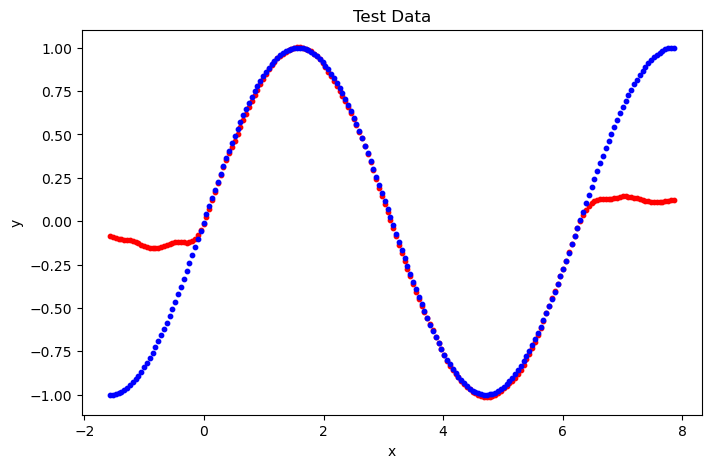

In [6]:
plt.figure(figsize=(8,5))
plt.scatter(x_test, trained_model.forward(x_test).detach(), color='red', s=10)
plt.scatter(x_test, y_test, color='blue', s=10)
plt.title("Test Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [7]:
trained_model.update_precision_from_loader(train_loader)
covariance = trained_model.invert_covariance()

/Users/shanewilliams/GradSchool/Fall2025/Statistical_Pattern_Recognition/gp_vs_sngp/sngp/model.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(covariance_RR, dtype=torch.float32).to(device)


/Users/shanewilliams/GradSchool/Fall2025/Statistical_Pattern_Recognition/gp_vs_sngp/sngp/model.py:57: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1741562938389/work/aten/src/ATen/native/TensorShape.cpp:3729.)
  var_pred = features_R1.T @ covariance @ features_R1
/var/folders/v1/94zh7tfn1vgcxh44wvvc48f40000gn/T/ipykernel_51986/2458393472.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(X_sorted, y_test_sorted, 'k--', c="red", linewidth=1, label='True function')


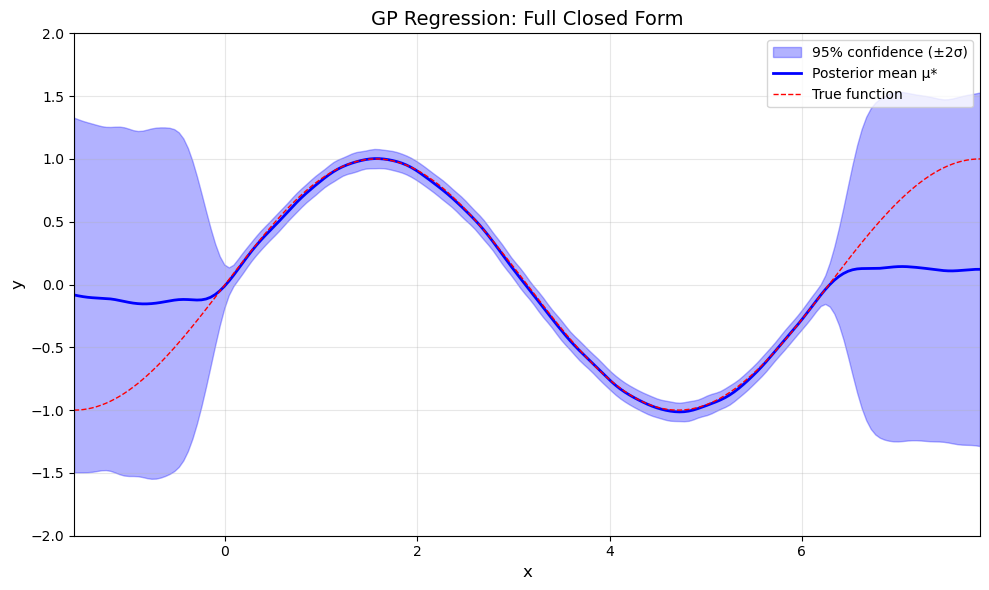

In [8]:
samples, mean, var = trained_model.predict(x_test.to(device), covariance=covariance, num_samples=20_000)
mean = mean.flatten()
var = torch.stack(var).squeeze()
std = torch.sqrt(var)

# Sort X_test and get sorting indices
X_sorted, sort_idx = torch.sort(x_test.squeeze())
X_sorted = X_sorted.detach().numpy()

# Apply same sorting to predictions and test values
mean_sorted = mean[sort_idx].detach().numpy()
std_sorted = std[sort_idx].detach().numpy()
y_test_sorted = y_test[sort_idx].detach().numpy()

# Evaluate true function at sorted X values
y_true_sorted = torch.sin(torch.tensor(X_sorted)).numpy()  # or however you define y

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

ax1 = axes
ax1.fill_between(
    X_sorted,
    mean_sorted - 2*std_sorted,
    mean_sorted + 2*std_sorted,
    alpha=0.3, color='blue', label='95% confidence (±2σ)'
)
ax1.plot(X_sorted, mean_sorted, 'b-', linewidth=2, label='Posterior mean μ*')
ax1.plot(X_sorted, y_test_sorted, 'k--', c="red", linewidth=1, label='True function')
#ax1.scatter(X_test.squeeze().detach().numpy(), y_test.detach().numpy(), 
            # c='red', s=100, zorder=5, label='Training data')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title('GP Regression: Full Closed Form', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(min(X_sorted), max(X_sorted))
ax1.set_ylim(-2, 2)

plt.tight_layout()
plt.savefig('full_gp_regression.png', dpi=600)